In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import random_split, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [ ]:
#Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
#load dataset and split into training and validation 0.8:0.2
dataset = torchvision.datasets.FashionMNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data',train=False,transform=transforms.ToTensor())
tsize = int(0.8*len(dataset))
vsize = len(dataset)-tsize
train_dataset,val_dataset = random_split(dataset,[tsize,vsize])


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 168kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.18MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 27.0MB/s]


In [ ]:

train_loader = DataLoader(train_dataset,batch_size=100,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=100,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=100,shuffle=False)


In [ ]:
#define module
class net(nn.Module):
  def __init__(self):
    super(net,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.conv2 = nn.Conv2d(32,64, kernel_size=3)
    self.conv3 = nn.Conv2d(64,128, kernel_size=3)
    self.fc1 = nn.Linear(128 , 64)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(64, 10)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    x = torch.flatten(x,1)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x




In [ ]:
#hyperparameters
isize = 784
epochs = 40
batch = 100
lr = 0.001

In [ ]:

#training loop
model = net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)


Epoch [1/40], Step [100/480], Loss: 1.2127
Epoch [1/40], Step [200/480], Loss: 0.9650
Epoch [1/40], Step [300/480], Loss: 0.8003
Epoch [1/40], Step [400/480], Loss: 0.8041
Saved best model at epoch 0 with val loss 0.7038
Epoch [2/40], Step [100/480], Loss: 0.4880
Epoch [2/40], Step [200/480], Loss: 0.6156
Epoch [2/40], Step [300/480], Loss: 0.6094
Epoch [2/40], Step [400/480], Loss: 0.6197
Saved best model at epoch 1 with val loss 0.6099
Epoch [3/40], Step [100/480], Loss: 0.7448
Epoch [3/40], Step [200/480], Loss: 0.5649
Epoch [3/40], Step [300/480], Loss: 0.6048
Epoch [3/40], Step [400/480], Loss: 0.5294
Saved best model at epoch 2 with val loss 0.5466
Epoch [4/40], Step [100/480], Loss: 0.6270
Epoch [4/40], Step [200/480], Loss: 0.4893
Epoch [4/40], Step [300/480], Loss: 0.3200
Epoch [4/40], Step [400/480], Loss: 0.5275
Saved best model at epoch 3 with val loss 0.5110
Epoch [5/40], Step [100/480], Loss: 0.4158
Epoch [5/40], Step [200/480], Loss: 0.5285
Epoch [5/40], Step [300/480], 

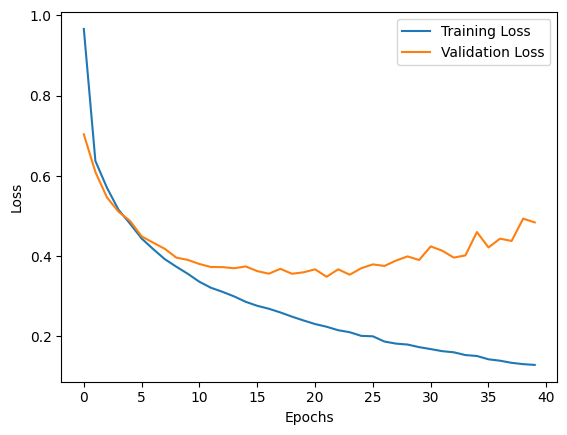

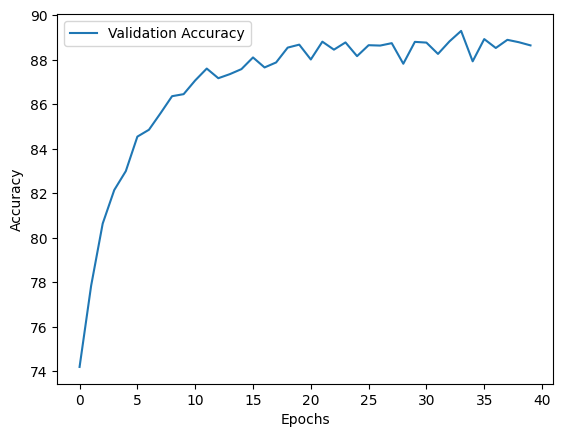

In [ ]:
nt = len(train_loader)
nv = len(val_loader)
best_val_loss = float('inf')
best_model_path = 'model_weights.pth'
val_accuracies = []
val_losses = []
train_loss = []


for epoch in range(epochs):
  trsloss = 0
  for i,(images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs,labels)
    trsloss += loss.item()

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1)%100 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{nt}], Loss: {loss.item():.4f}')
  train_loss.append(trsloss/len(train_loader))

  #validation loop
  with torch.no_grad():
    nc = 0
    ns = len(val_loader.dataset)
    nv = len(val_loader)
    lossval = 0
    for images,labels in val_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      lossval += criterion(outputs,labels).item()

      _,predicted = torch.max(outputs.data,1)
      nc += (predicted==labels).sum().item()


    val_accuracies.append(100*nc/ns)
    val_losses.append(lossval/nv)
    val_loss = lossval/nv
    if val_loss < best_val_loss: #save best model
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model at epoch {epoch} with val loss {val_loss:.4f}")

#plots loss and accuracy curves

plt.plot(train_loss,label='Training Loss')
plt.plot(val_losses,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(val_accuracies,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model = net().to(device)
model.load_state_dict(torch.load('model_weights.pth'))
with torch.no_grad():
  nc = 0
  ns = len(test_loader.dataset)
  for images,labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      outs = model(images)

      _,pred = torch.max(outs,1)
      nc = nc + (pred == labels).sum().item()
  print("Accuracy over",ns ,"is ", 100*nc/ns)

Accuracy over 10000 is  88.65
